In [1]:
# %cd notebooks

In [2]:
import matplotlib.backends
import torch
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import cartopy.crs as ccrs 
import matplotlib 
from tqdm.notebook import tqdm
from models.model import Wang2024
from models.data import load_output_data, load_input_data, get_rain_bool, xarray_to_dataloaders
from models.training import train_loop, eval_loop, evaluate_model

from captum.attr import Occlusion, IntegratedGradients


plt.style.use('robin')


In [3]:
%matplotlib inline

In [4]:

ds_ml= xr.open_dataset('/Data/gfi/users/rogui7909/era5_rain_norge/DL_era5_rain_regression_in_out.nc').sel(mask_id=[14]).sel(time=slice(None,'2021'))
ds_ml = ds_ml.where(ds_ml.data_in.count(['longitude', 'latitude']).sum('var_name')==24576, drop=True)
ds_ml['data_in'] = ds_ml.data_in.sel(var_name=['z500'])

ds_ml = ds_ml.where(ds_ml.data_in.count(['longitude', 'latitude'])==24576//3, drop=True)
ds_ml['data_out'] = (ds_ml.data_out.rank('time', pct=True)//.1).astype(int)
time = ds_ml.time 

    

In [5]:
device ='cpu'
model = Wang2024(num_classes=10, num_channels_in=1, image_size=128*64, groups=1).to(device)
model.load_state_dict(torch.load('trained_models/wang2024_z500_ERA5_norwaeyW_precip_10quantiles.torch', weights_only=True))
model.eval()

for param in model.parameters():
    param.requires_grad = False

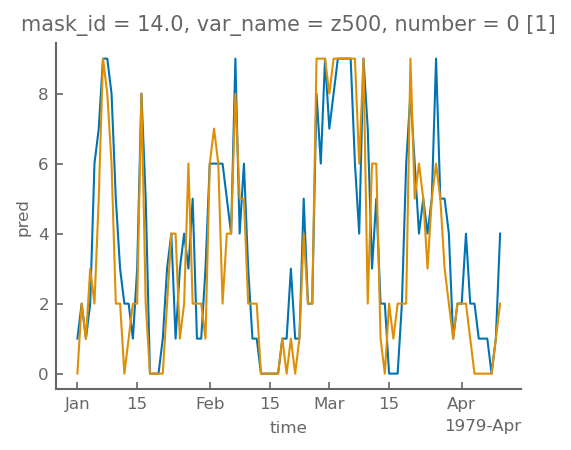

In [6]:

model.eval()
with torch.no_grad():
    model = model.cpu()
    data_in = ds_ml.data_in.values
    X = torch.tensor(data_in).type(torch.float32)
    pred = torch.softmax(model(X), dim=1).detach().numpy()

    pred_ds = xr.DataArray(pred, dims = ['time','quantile'], coords=dict(time=ds_ml.time, quantile=np.arange(0,10)))
    ds_eval = xr.Dataset(dict(truth=ds_ml.data_out.squeeze(), pred_proba=pred_ds, pred=pred_ds.idxmax('quantile'))).sortby('time')


# ds_eval_destandard = ds_eval*ds_ml_std + ds_ml_mean
# ds_eval_destandard = np.exp(ds_eval) + 1e-5
ds_eval.truth.isel(time=slice(0,100)).plot()
ds_eval.pred.isel(time=slice(0,100)).plot()
plt.show()


<Axes: xlabel='pred', ylabel='truth'>

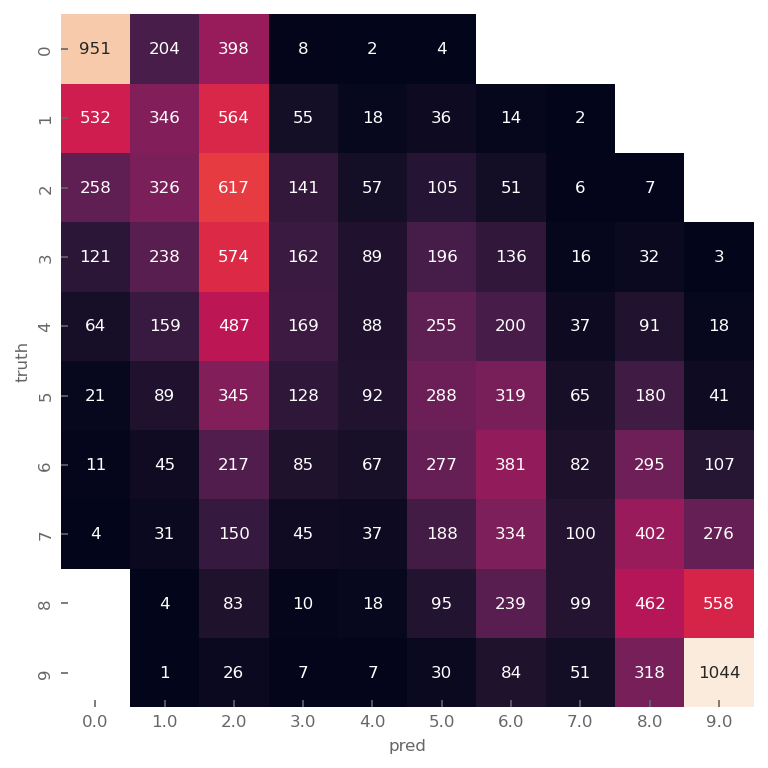

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
df_ = ds_eval[['truth','pred']].to_dataframe()

sns.heatmap(df_.groupby(['truth','pred']).count().unstack().mask_id,
            square=True, cbar=False, annot=True, fmt = '.0f', ax=ax
    )

# XAI

In [9]:
from captum.attr import LRP,DeepLiftShap, Occlusion,IntegratedGradients,NoiseTunnel, DeepLift, Saliency

lrp = LRP(model.to('cpu'))
dlShap =  DeepLiftShap(model.to('cpu'))
dl =  DeepLift(model.to('cpu'))
ig = IntegratedGradients(model.to('cpu'))
ig_noinput = IntegratedGradients(model.to('cpu'),multiply_by_inputs=False)
nt = NoiseTunnel(ig)
nt_noinput = NoiseTunnel(ig_noinput)
sal = Saliency(model)
occ = Occlusion(model.to('cpu'))

In [10]:
ds_over90 = ds_ml.sel(time = df_.query("pred==9&truth==9").index.get_level_values(0)) # 30 is approx 99 percentile
ds_below10 = ds_ml.sel(time = df_.query("pred==0&truth==0").index.get_level_values(0)) # 30 is approx 99 percentile

ds_valid = ds_ml.sel(time = df_.query("pred==truth").index.get_level_values(0)) # 30 is approx 99 percentile
ds_valid_winter = ds_valid.where(ds_valid.time.dt.season=='DJF', drop=True)

In [11]:
input_ds = ds_valid_winter
input_tensor = torch.Tensor(input_ds.data_in.values).to('cpu')
targets = torch.Tensor(input_ds.data_out.values.squeeze().astype(int)).type(torch.long)
baseline = torch.Tensor(input_ds.data_in.mean('time').values)
all_attr = []
with torch.no_grad():
    for i in tqdm(range(input_tensor.shape[0])):
        # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline, target=targets[i]).detach().numpy()
        attr_ig_target0 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=0).detach().numpy()
        attr_ig_target3 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=2).detach().numpy()
        attr_ig_target6 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=6).detach().numpy()
        # attr_ig_target4 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=4).detach().numpy()
        attr_ig_target9 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=9).detach().numpy()
        all_attr.append(np.concatenate([attr_ig_target0,attr_ig_target3,attr_ig_target6,attr_ig_target9]))

ds_attrs_quant_valid = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
            dims=['target','time','var_name','latitude','longitude'], 
            coords= dict(time=input_ds.time,
                        longitude=input_ds.longitude, 
                        latitude=input_ds.latitude,
                        var_name=input_ds.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                        target=[0,2,6,9]))
ig_noinput

  0%|          | 0/1198 [00:00<?, ?it/s]

In [12]:
ds_mean_winter_attrs = ds_attrs_quant_valid.squeeze().groupby(ds_valid_winter.squeeze().data_out).mean('time')
ds_mean_winter = ds_valid_winter.data_in.squeeze().groupby(ds_valid_winter.squeeze().data_out).mean('time')

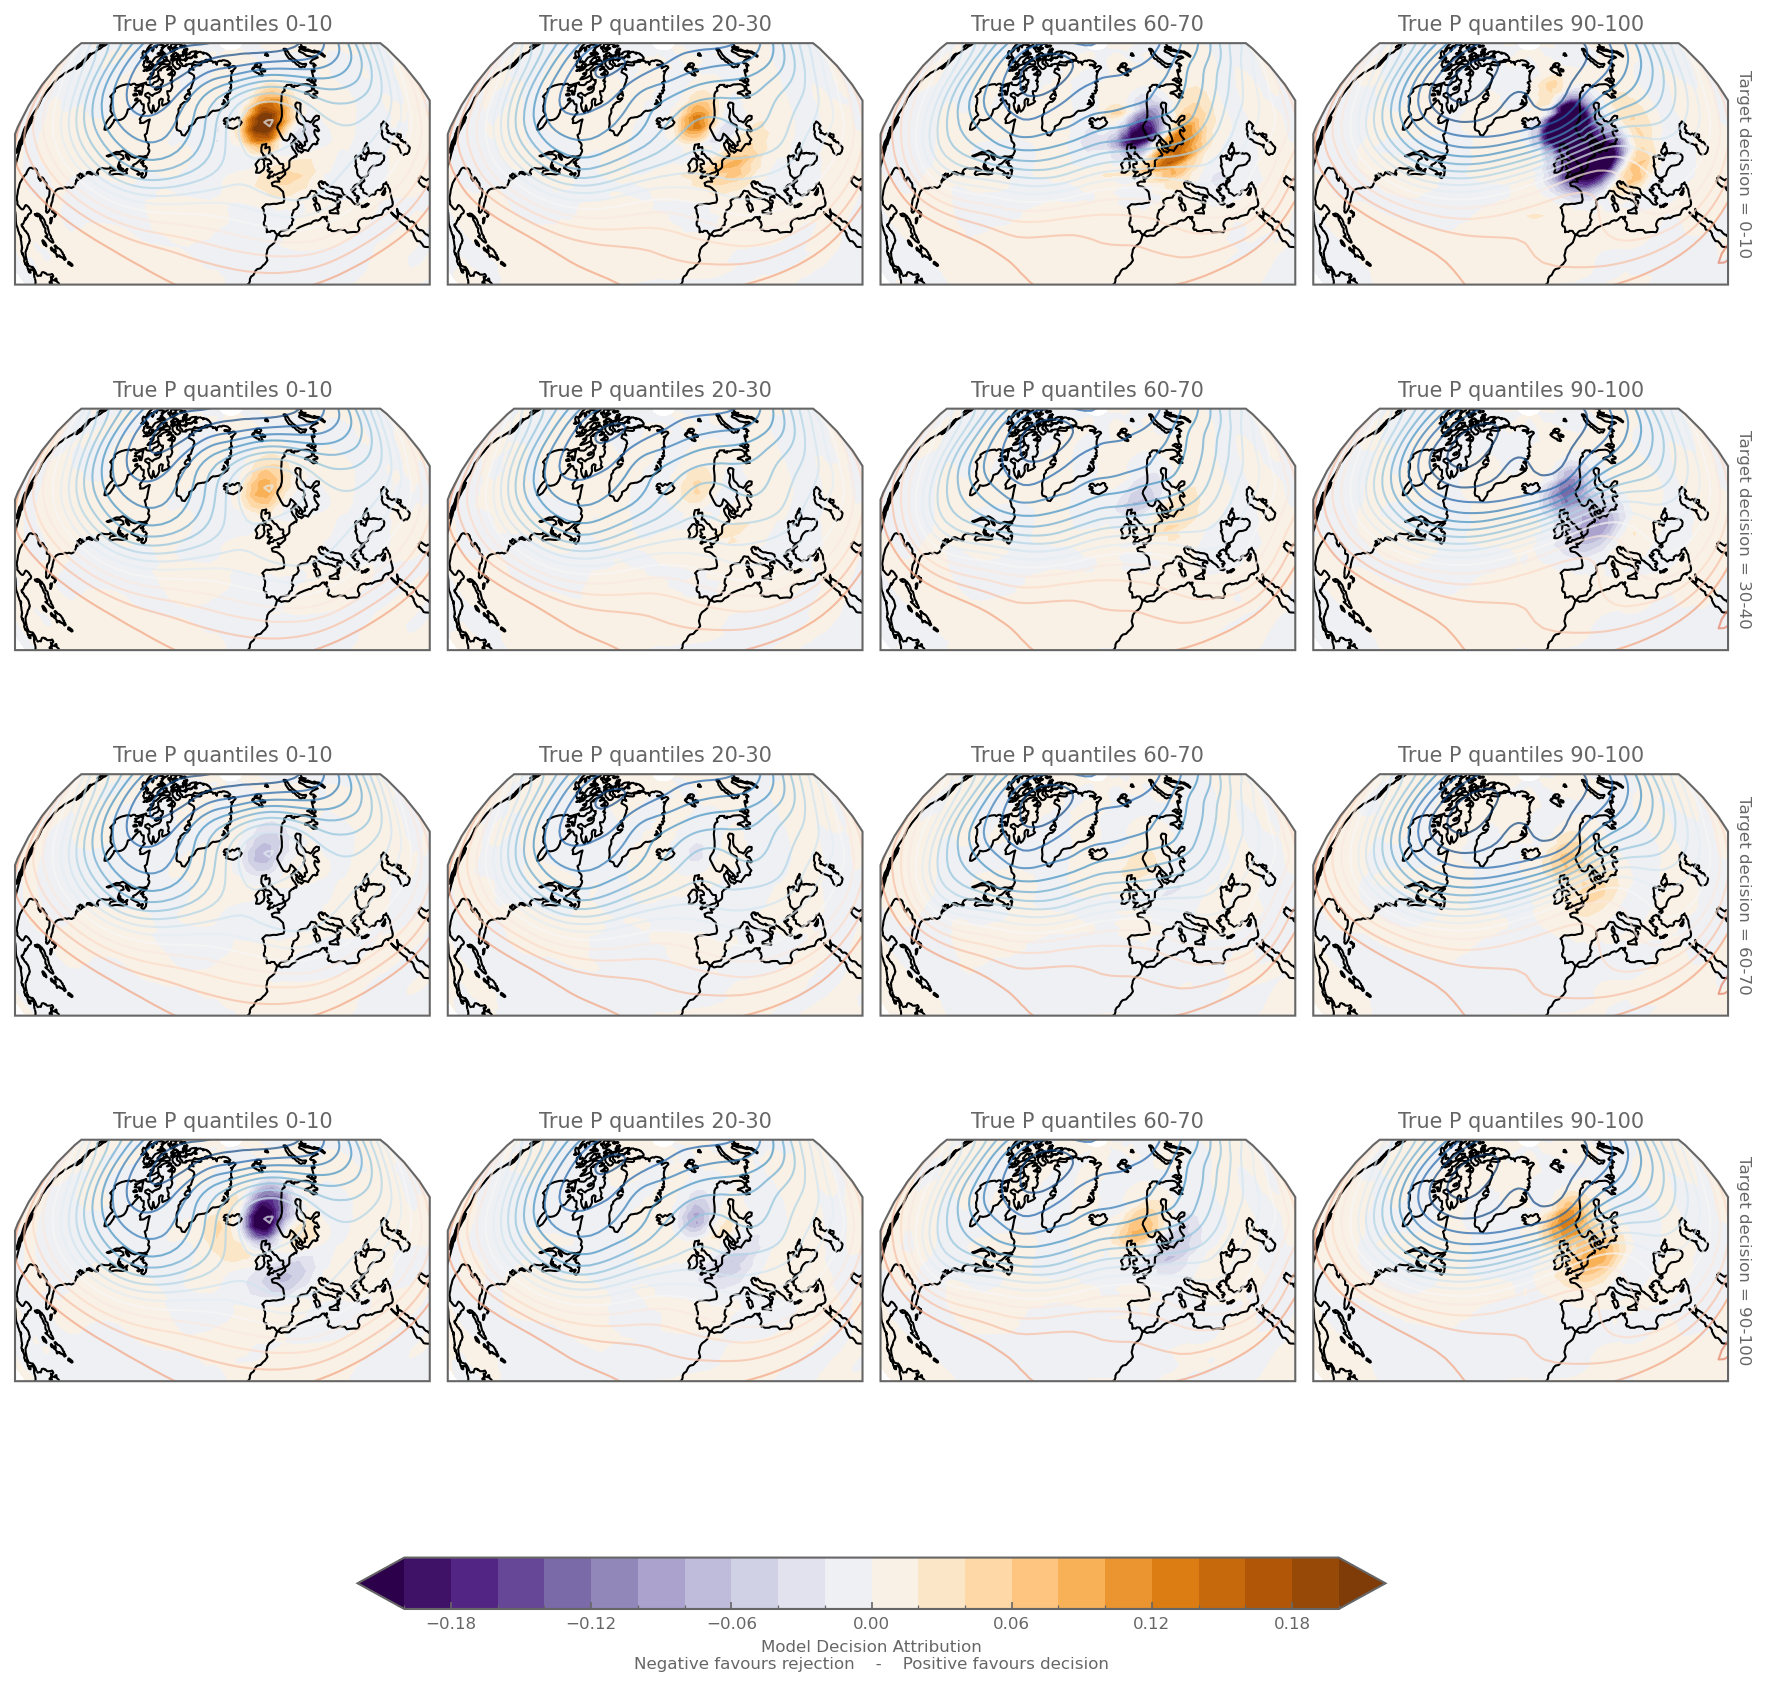

In [13]:
cols = [0,2,6,9]

plot = ds_mean_winter_attrs.assign_coords(target=['0-10','30-40','60-70','90-100']).rename(target = 'Target decision').rolling(longitude=5, latitude=5, center=True).mean().sel(data_out=cols).plot.contourf(
                                                                         subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                                                         col ='data_out', row='Target decision',
                                                                         transform=ccrs.PlateCarree(), levels=np.arange(-0.2,0.21,.02), vmax=.5,extend='both', cmap='PuOr_r',
                                                                         size=3, aspect=0.9,
                                                                         cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))
for k,ax in enumerate(plot.axs.flatten()):
    row = k//len(cols)
    col = k%len(cols)
    ds_mean_winter.sel(data_out=cols[col]).plot.contour(ax=ax,levels=np.arange(-2,2.1,.2),
                                            transform=ccrs.PlateCarree(), alpha=.7)
        # mean_attrs = ds_mean_winter_attrs.isel(data_out=k).rolling(longitude=5, latitude=5, center=True).mean()
        # mean_attrs = mean_attrs.where(np.abs(mean_attrs)>0.1)
        # mean_attrs.plot.contourf(transform=ccrs.PlateCarree(),ax=ax, levels=10, vmax=.4, vmin=-.4, add_colorbar=False, cmap='RdBu_r')
    ax.coastlines()
    ax.set_extent((-90,40, 10,90))
    if row==4:
        ax.set_ylabel('coucou')
    
    ax.set_title(f"True P quantiles {cols[col]*10}-{(cols[col]+1)*10}")

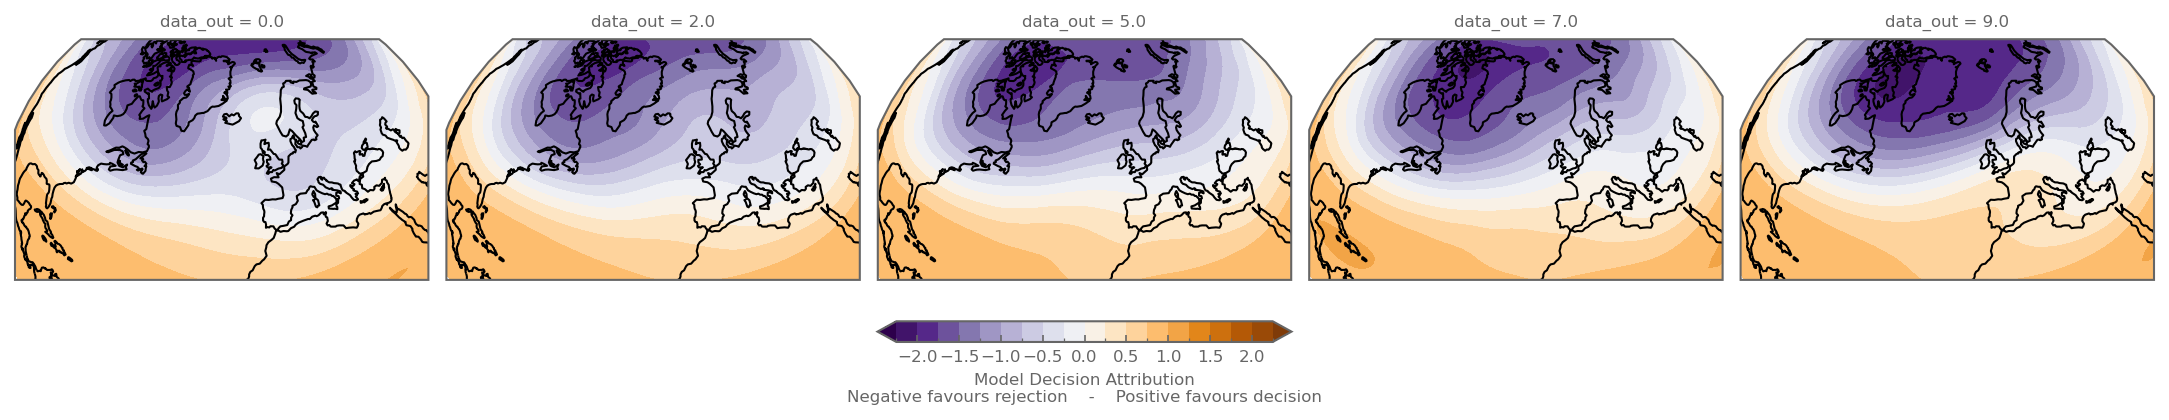

In [281]:
plot = ds_mean_winter.sel(data_out=cols).plot.contourf(subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                    col ='data_out',col_wrap=5,
                                    transform=ccrs.PlateCarree(), levels=20, extend='both', cmap='PuOr_r',
                                    size=3, aspect=0.9,
                                    cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))
for k,ax in enumerate(plot.axs.flatten()):
    ax.coastlines()
    ax.set_extent((-90,40, 10,90))



In [13]:

ds_bad90 = ds_ml.sel(time = df_.query("pred==2&truth==9").index.get_level_values(0)) # 30 is approx 99 percentile
ds_bad90_winter = ds_bad90.where(ds_bad90.time.dt.season=='DJF', drop=True)

In [14]:
input_ds = ds_bad90_winter
input_tensor = torch.Tensor(input_ds.data_in.values).to('cpu')
targets = torch.Tensor(input_ds.data_out.values.squeeze().astype(int)).type(torch.long)
baseline = torch.Tensor(ds_ml.data_in.mean('time').values)
all_attr = []
with torch.no_grad():

    for i in tqdm(range(input_tensor.shape[0])):
        # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline, target=targets[i]).detach().numpy()
        attr_ig_target2 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=2).detach().numpy()
        # attr_ig_target4 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=4).detach().numpy()
        attr_ig_target9 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=9).detach().numpy()
        all_attr.append(np.concatenate([attr_ig_target2,attr_ig_target9]))

ds_attrs_quant_bad90 = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
            dims=['target','time','var_name','latitude','longitude'], 
            coords= dict(time=input_ds.time,
                        longitude=input_ds.longitude, 
                        latitude=input_ds.latitude,
                        var_name=input_ds.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                        target=[2,9]))

  0%|          | 0/13 [00:00<?, ?it/s]

In [42]:
with torch.no_grad():
    print(np.argmax(model(input_tensor).detach().numpy(), axis=1))


[9 9 2 9 9 9 9 2 9 9 5 9 9]


In [43]:
ds_mean_winter_attrs_bad90 = ds_attrs_quant_valid.mean('time')
ds_mean_winter_bad90 = ds_bad90_winter.mean('time')

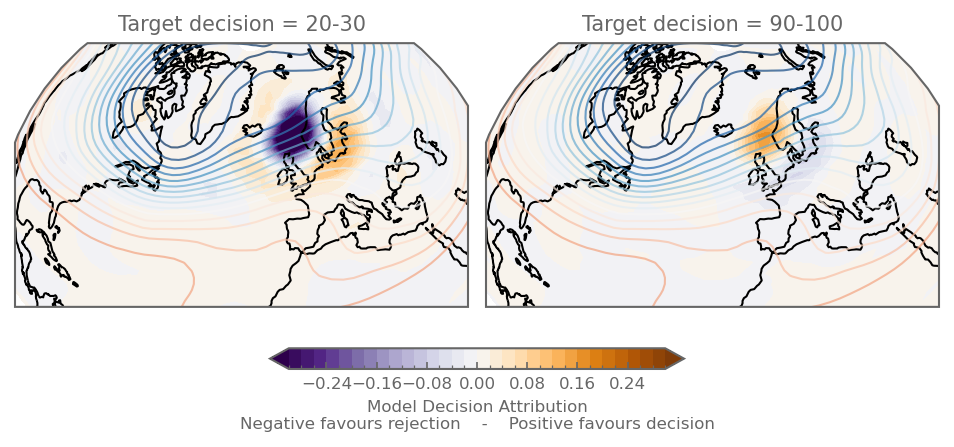

In [44]:
plot = ds_mean_winter_attrs_bad90.squeeze().assign_coords(target=['20-30','90-100']).rename(target = 'Target decision').rolling(longitude=5, latitude=5, center=True).mean().plot.contourf(
                                                                         subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                                                        col='Target decision',
                                                                         transform=ccrs.PlateCarree(), levels=np.arange(-0.3,0.31,.02), vmax=.5,extend='both', cmap='PuOr_r',
                                                                         size=3, aspect=0.9,
                                                                         cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))
for k,ax in enumerate(plot.axs.flatten()):
    title = ax.get_title()
    ds_mean_winter_bad90.data_in.squeeze().plot.contour(ax=ax,levels=np.arange(-2,2.1,.2),
                                            transform=ccrs.PlateCarree(), alpha=.7)
    ax.set_title(title)
        # mean_attrs = ds_mean_winter_attrs.isel(data_out=k).rolling(longitude=5, latitude=5, center=True).mean()
        # mean_attrs = mean_attrs.where(np.abs(mean_attrs)>0.1)
        # mean_attrs.plot.contourf(transform=ccrs.PlateCarree(),ax=ax, levels=10, vmax=.4, vmin=-.4, add_colorbar=False, cmap='RdBu_r')
    ax.coastlines()
    ax.set_extent((-90,40, 10,90))
    if row==4:
        ax.set_ylabel('coucou')
    


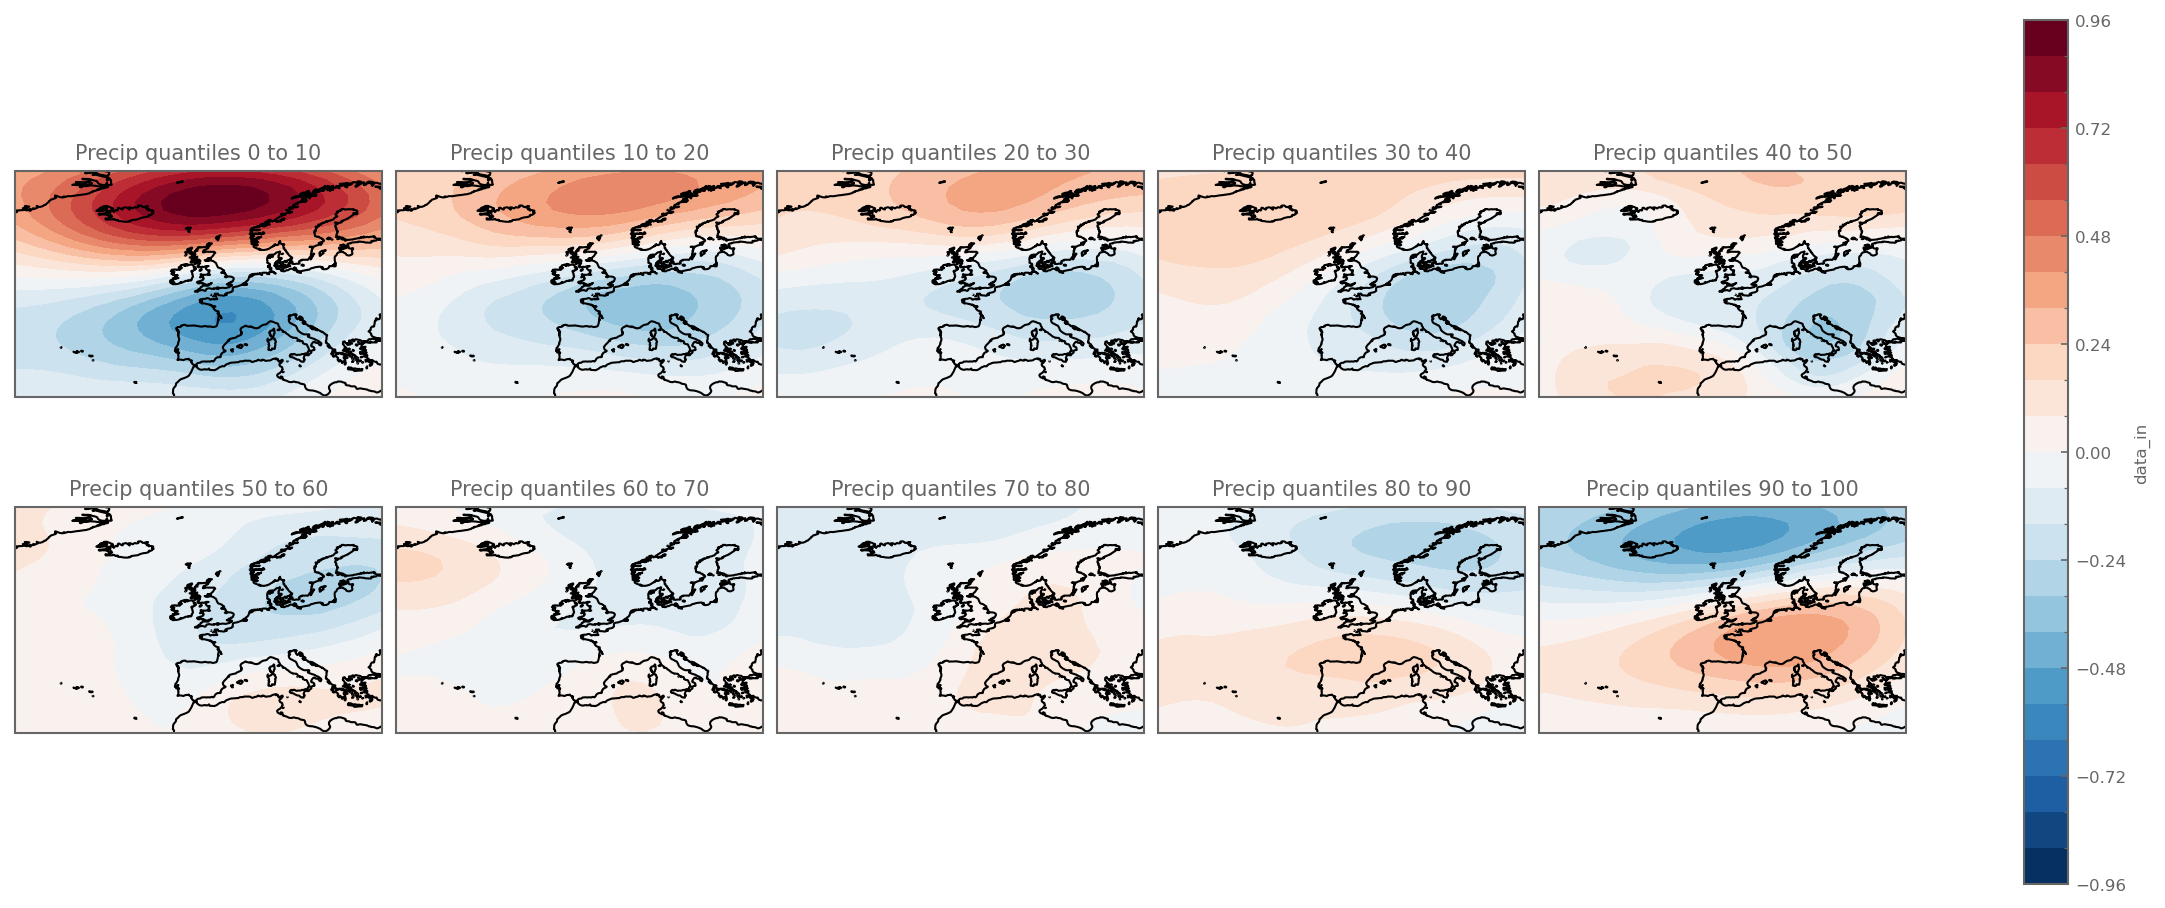

In [232]:
plot = (ds_mean_winter - ds_valid_winter.data_in.mean('time')).squeeze().plot.contourf(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                                                         col ='data_out', col_wrap=5,
                                                                         transform=ccrs.PlateCarree(), levels=30)
for k,ax in enumerate(plot.axs.flatten()):
    if k<10:
        # mean_attrs = ds_mean_winter_attrs.isel(data_out=k).rolling(longitude=5, latitude=5, center=True).mean()
        # mean_attrs = mean_attrs.where(np.abs(mean_attrs)>0.1)
        # mean_attrs.plot.contourf(transform=ccrs.PlateCarree(),ax=ax, levels=10, vmax=.4, vmin=-.4, add_colorbar=False, cmap='RdBu_r')
        ax.coastlines()
        ax.set_extent((-40,30, 30,70))
        ax.set_title(f"Precip quantiles {k*10} to {(k+1)*10}")

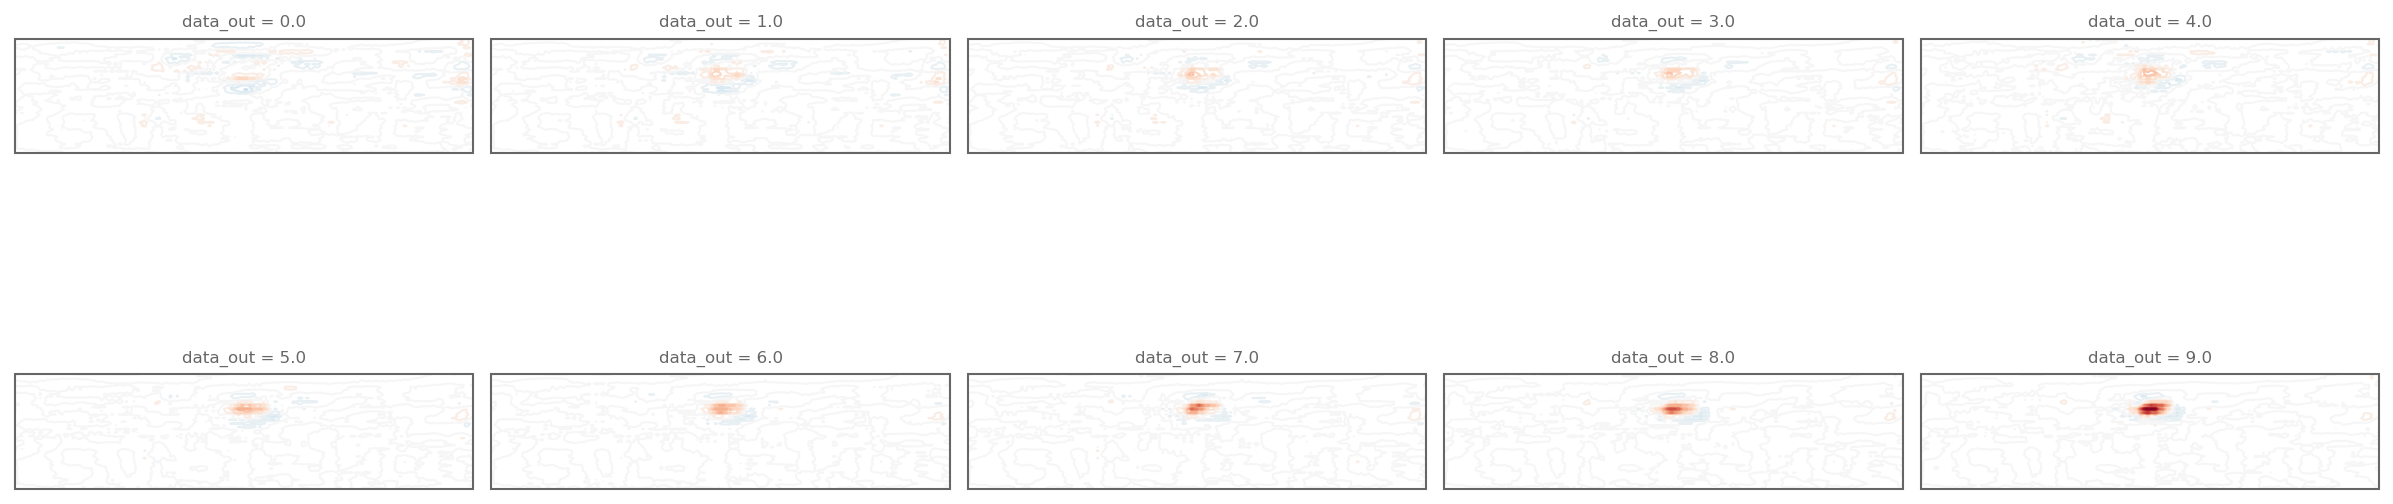

In [130]:
plot = ds_mean_winter_attrs.plot.contour(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                                                         col ='data_out', col_wrap=5,
                                                                         transform=ccrs.PlateCarree(), levels=30)

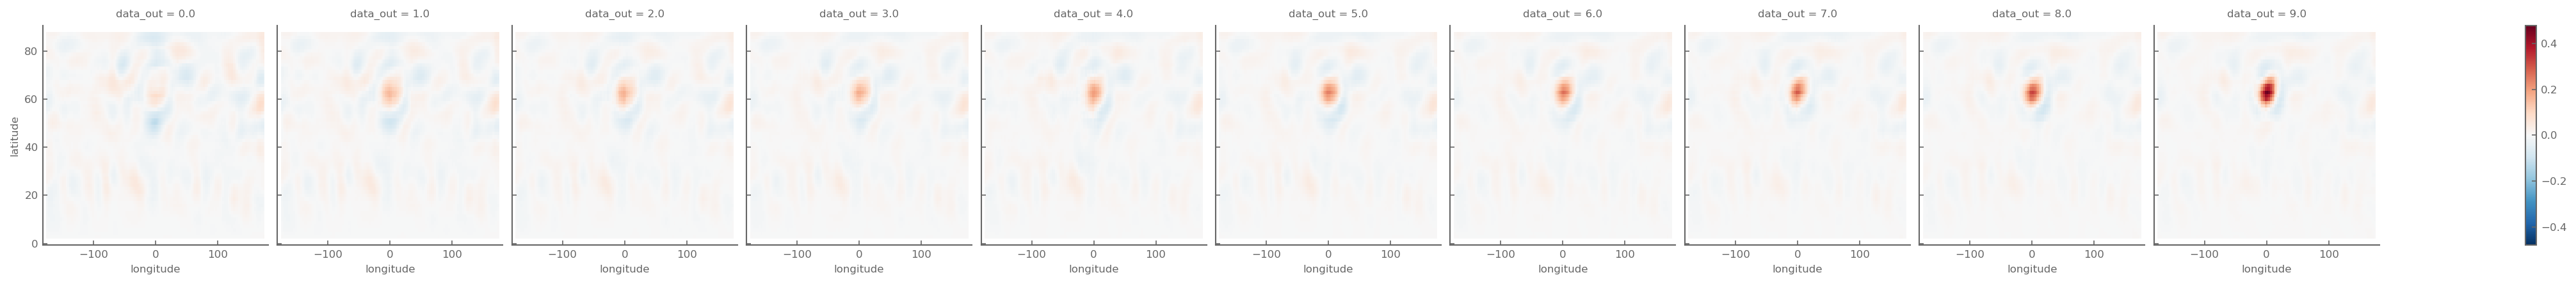

In [113]:
ds_mean_winter_attrs.rolling(longitude=5, latitude=5, center=True).mean().plot(col='data_out')

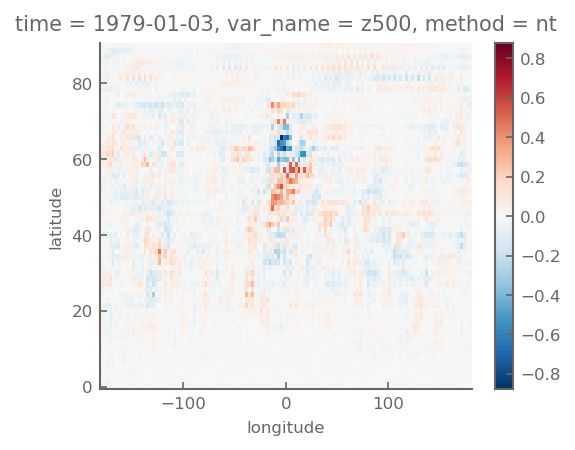

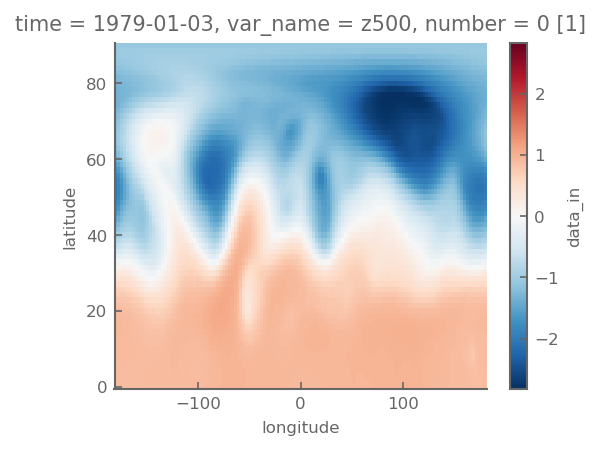

In [24]:
ds_attrs_quant.isel(time=0).plot()
plt.figure()
ds_valid.data_in.isel(time=0).plot()

In [11]:
all_quant = []
for quant in range(10):
    ds_quant_truth = ds_ml.sel(time = df_.query(f"pred=={quant}&truth=={quant}").index.get_level_values(0))
    input_tensor = torch.Tensor(ds_quant_truth.data_in.values).to('cpu')
    baseline = torch.zeros_like(input_tensor)

    all_attr = []
    for i in tqdm(range(input_tensor.shape[0])):
        attr_ig = ig.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
        all_attr.append(np.concatenate([attr_ig]))

    ds_attrs_quant = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
                dims=['method','time','var_name','latitude','longitude'], 
                coords= dict(time=ds_quant_truth.time,
                            longitude=ds_quant_truth.longitude, 
                            latitude=ds_quant_truth.latitude,
                            var_name=ds_quant_truth.var_name, 
                            #   method=['ig','nt','deeplift','occ']))
                            method=['nt']))
    ds_attrs_mean_quant = ds_attrs_quant.mean('time').assign_coords(q=quant*10)
    all_quant.append(ds_attrs_mean_quant)
    # print(ds_quant_truth.time.size)


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/1118 [00:00<?, ?it/s]

In [12]:
ds_attr = xr.concat(all_quant, dim='q')

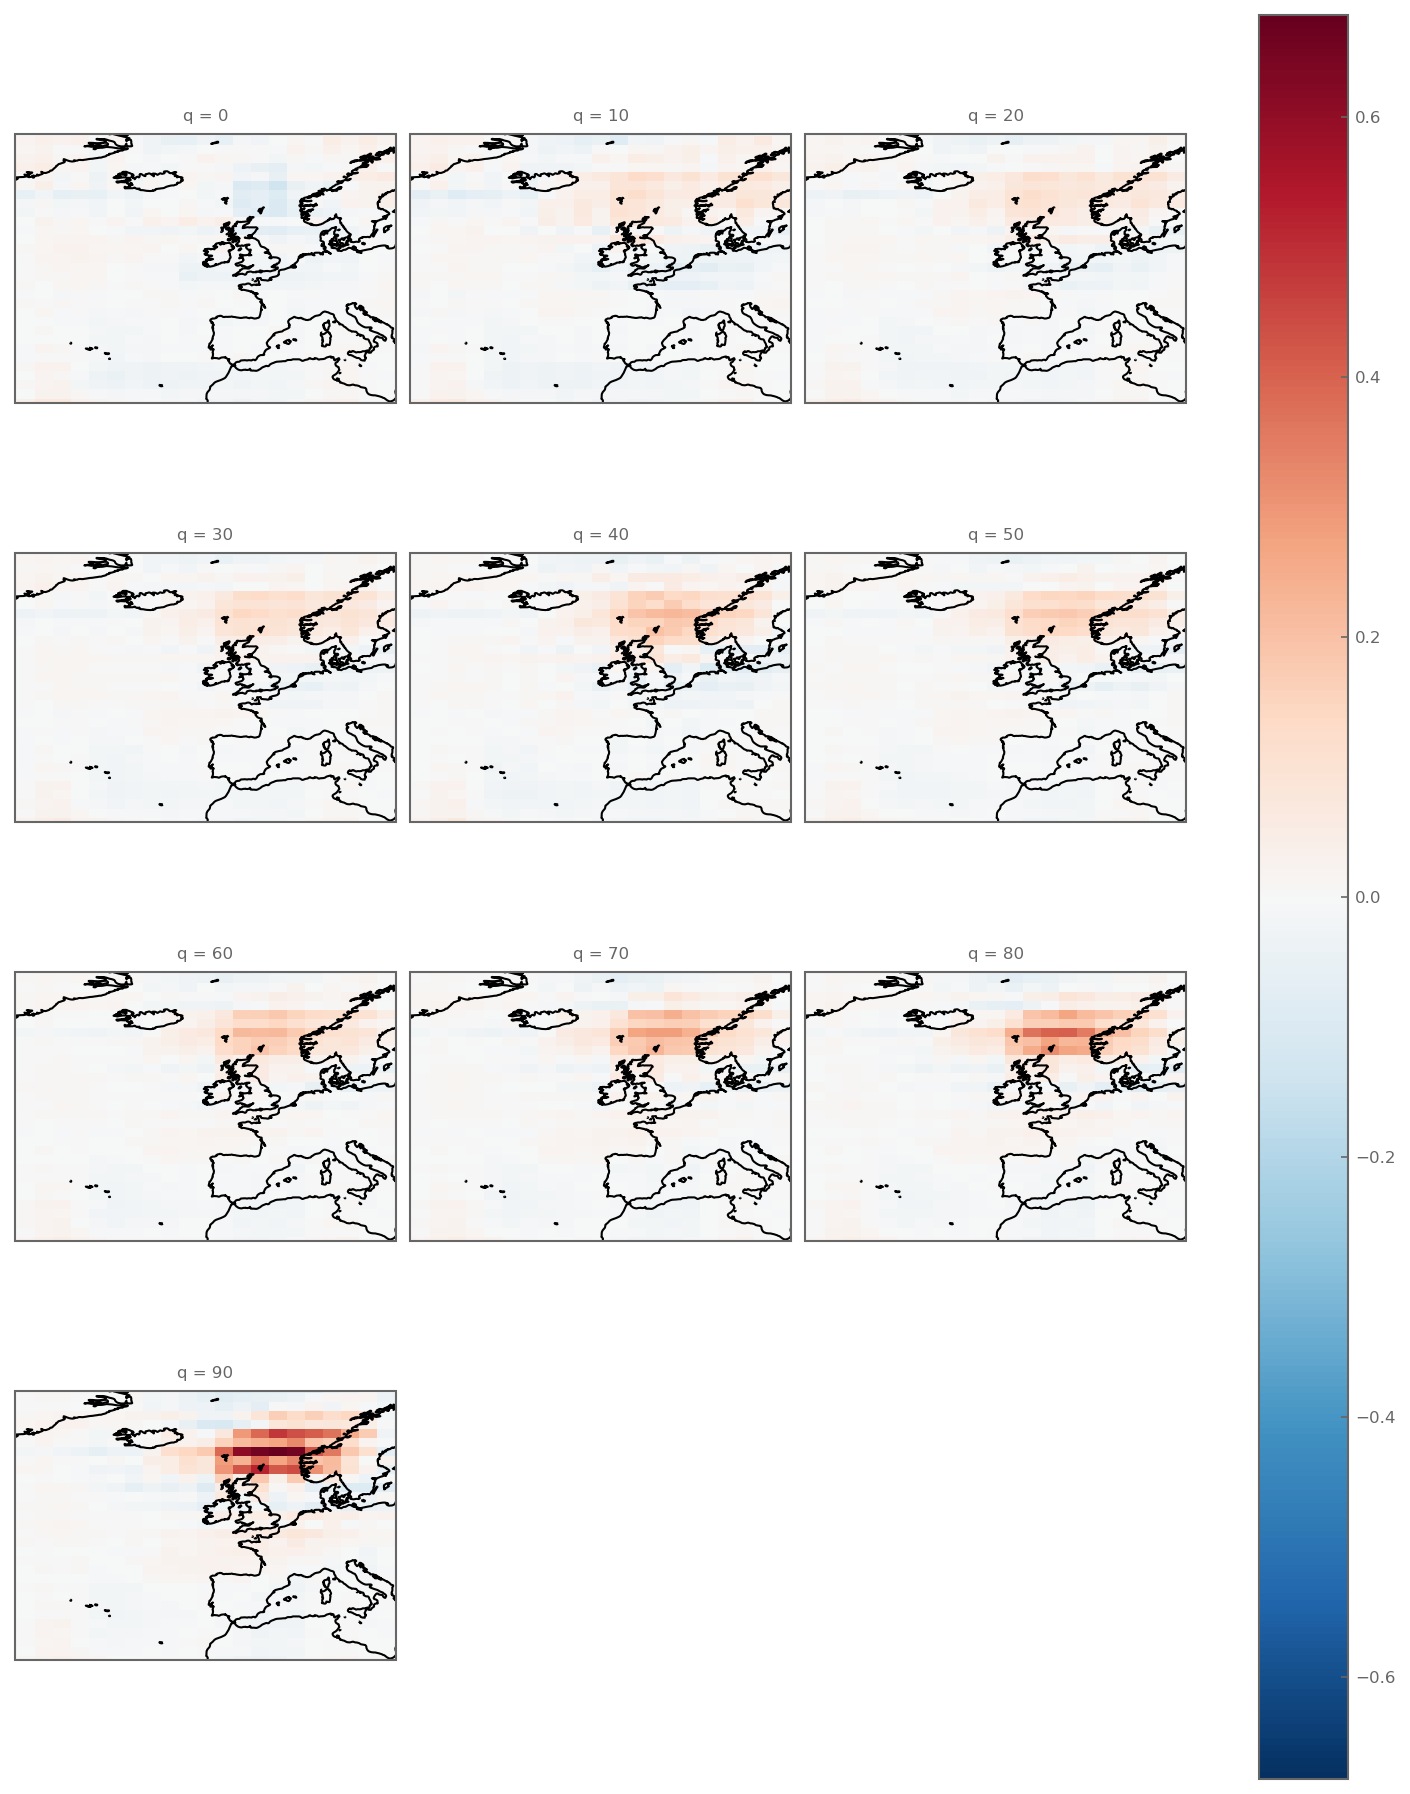

In [16]:
plot = ds_attr.squeeze().plot(subplot_kws = dict(projection=ccrs.PlateCarree()),
                               col ='q', col_wrap=3,
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))

In [ ]:
input_tensor = torch.Tensor(ds_over90.data_in.values).to('cpu')
baseline = torch.zeros_like(input_tensor)
target=9

all_attr = []
for i in tqdm(range(input_tensor.shape[0])):
    # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
    attr_ig = ig.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
    # attr_dl = dlShap.attribute(input_tensor[i:i+1], target=9).detach().numpy()
    # attr_occ = occ.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy()
    # all_attr.append(np.concatenate([attr_ig,attr_nt, attr_dl, attr_occ]))
    all_attr.append(np.concatenate([attr_ig]))


ds_attrs_above90 = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
             dims=['method','time','var_name','latitude','longitude'], 
             coords= dict(time=ds_over90.time,
                          longitude=ds_over90.longitude, 
                          latitude=ds_over90.latitude,
                          var_name=ds_over90.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                          method=['nt']))
ds_attrs_mean_above90 = ds_attrs_above90.mean('time')

# attrs_lrp = xr.DataArray(lrp.attribute(input_tensor, rule=).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_ig = xr.DataArray(np.concatenate(all_attr), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_nt = xr.DataArray(nt.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_occ = xr.DataArray(occ.attribute(input_tensor, baselines=baseline,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_dls = xr.DataArray(dlShap.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)


  0%|          | 0/1117 [00:00<?, ?it/s]

In [33]:
input_tensor = torch.Tensor(ds_below10.data_in.values).to('cpu')
baseline = torch.zeros_like(input_tensor)
target=9

all_attr = []
for i in tqdm(range(input_tensor.shape[0])):
    # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
    attr_ig = ig.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=0).detach().numpy()
    # attr_dl = dlShap.attribute(input_tensor[i:i+1], target=9).detach().numpy()
    # attr_occ = occ.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy()
    # all_attr.append(np.concatenate([attr_ig,attr_nt, attr_dl, attr_occ]))
    all_attr.append(np.concatenate([attr_ig]))


ds_attrs_below10 = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
             dims=['method','time','var_name','latitude','longitude'], 
             coords= dict(time=ds_below10.time,
                          longitude=ds_below10.longitude, 
                          latitude=ds_below10.latitude,
                          var_name=ds_below10.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                          method=['nt']))
ds_attrs_mean_below10 = ds_attrs_below10.mean('time')

# attrs_lrp = xr.DataArray(lrp.attribute(input_tensor, rule=).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_ig = xr.DataArray(np.concatenate(all_attr), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_nt = xr.DataArray(nt.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_occ = xr.DataArray(occ.attribute(input_tensor, baselines=baseline,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_dls = xr.DataArray(dlShap.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)


  0%|          | 0/998 [00:00<?, ?it/s]

AttributeError: 'GeoQuadMesh' object has no attribute 'axs'

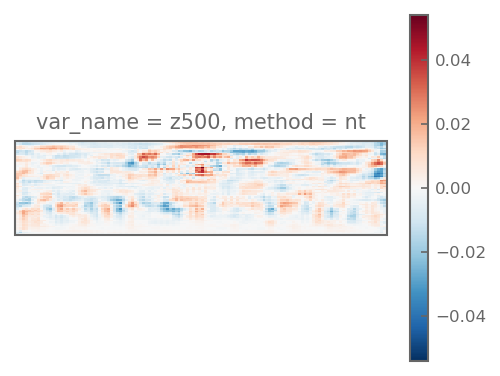

In [35]:
plot = ds_attrs_mean_below10.squeeze().plot(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))
    
plot = ds_attrs_mean_above90.squeeze().plot(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))

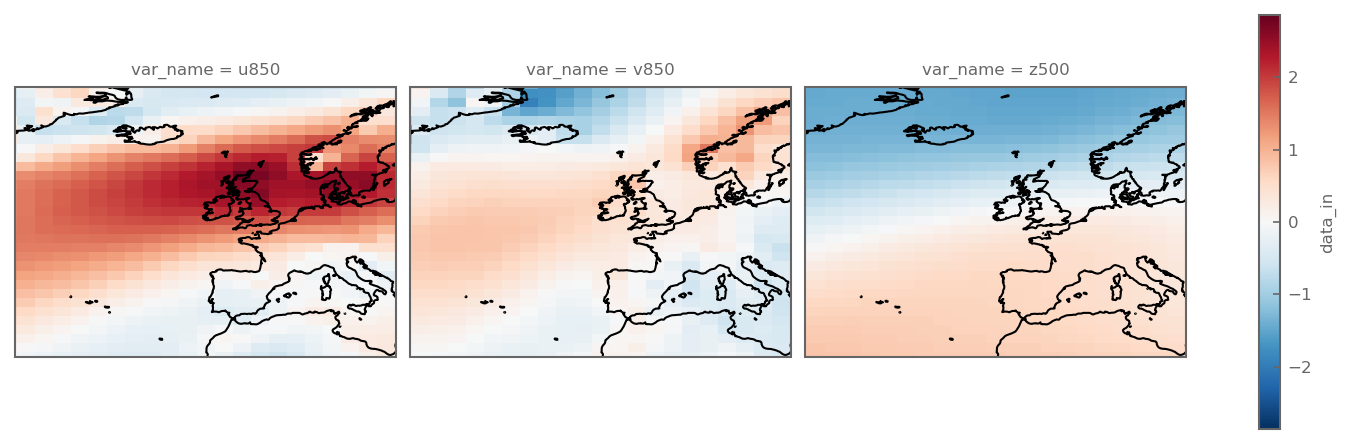

In [35]:

plot = ds_over90.data_in.mean('time').squeeze().plot(col='var_name', col_wrap=3, 
                                            subplot_kws = dict(projection=ccrs.PlateCarree()),
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))

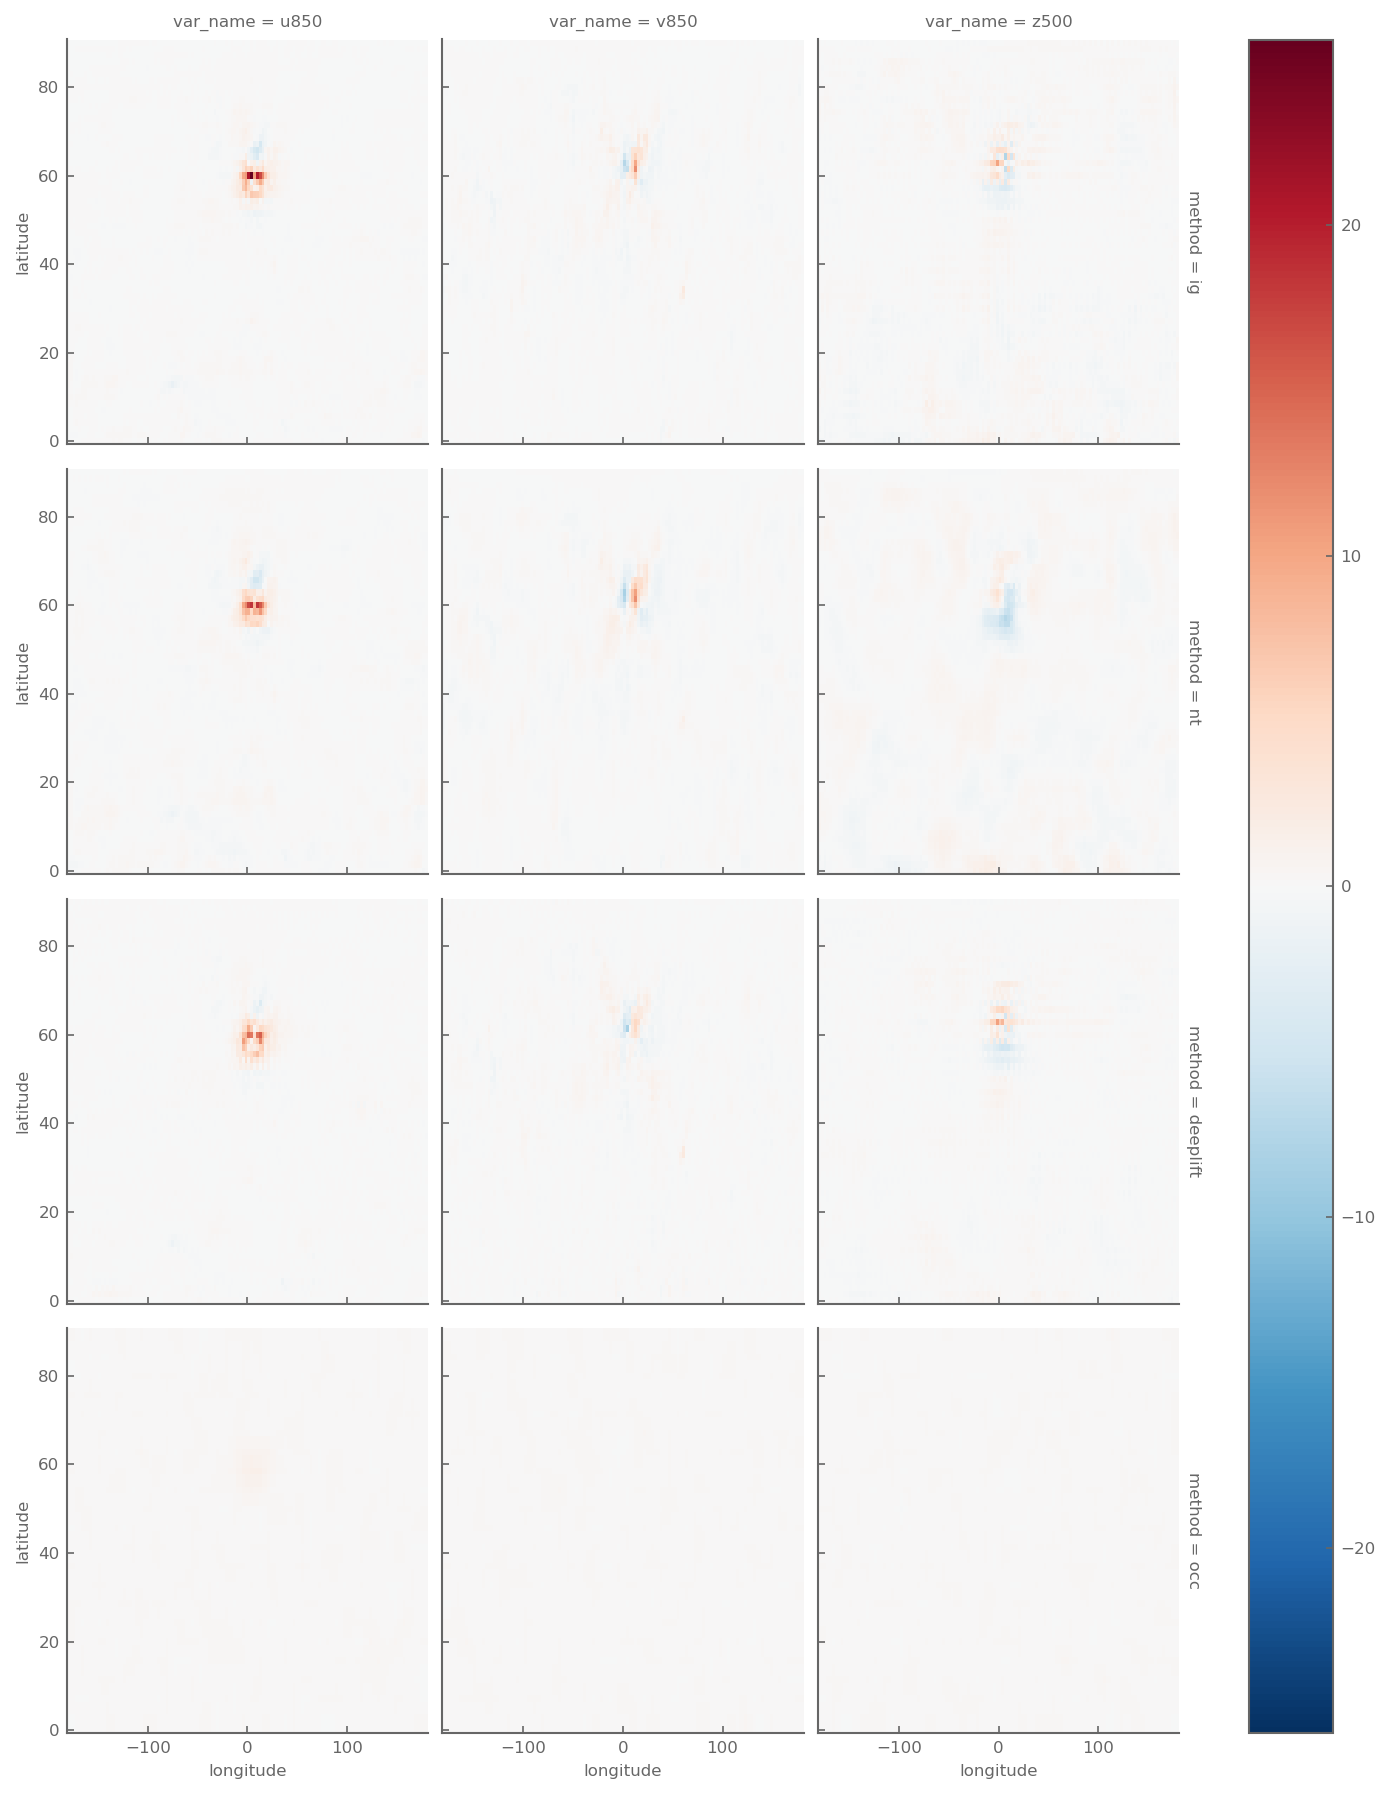

In [51]:
ds_attrs.mean('time').plot(col='var_name', row='method')

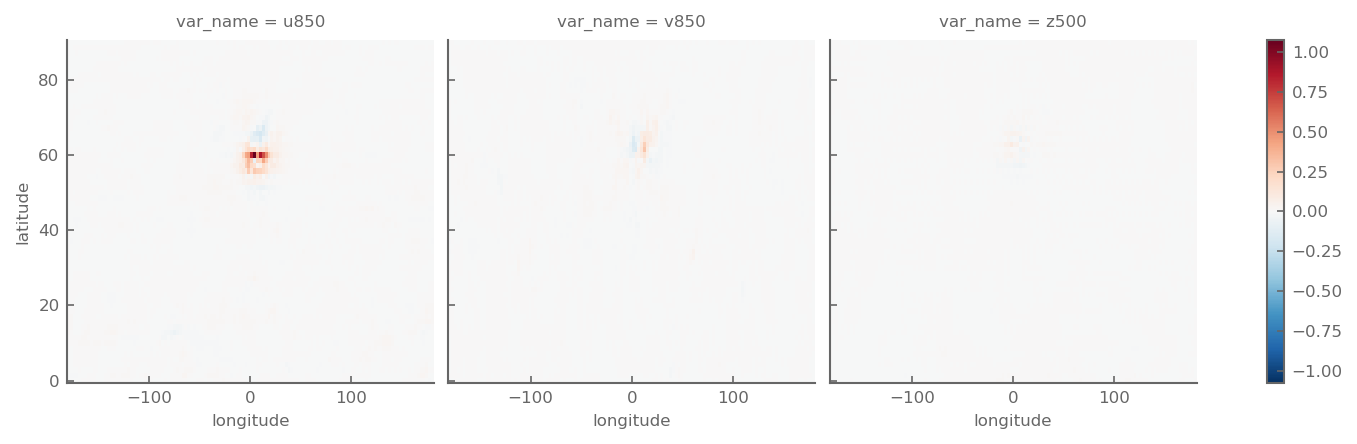

In [21]:
attrs_ig.mean('time').plot(col='var_name', robust=False)